# The scripts in the notebook are used for making Figure 1D

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from typing import List
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')


# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
# print(plt.style.available)
# plt.style.use('fivethirtyeight') 

# Helper functions

In [3]:
def get_mAbs(path:str, isotype:List[str]=None):
    """ 
    Method to get the monoclonal antibodies from the HLA Epitope Registry 
    
    Parameters:
    -----------
        path: str
            Path to the epitope database

        isotype: List[str], default None
            In default mode, all the monoclonal antibodies are included irrespective of their isotype.
    """

    epitope_df = pd.read_pickle(path)
    ind_mab = epitope_df.mAb == 'Yes'
    if isotype:
        ind_isotype = epitope_df['isotype'].apply(lambda x: x in isotype)
    else:
        ind_isotype = True
    return  set(epitope_df[ind_mab & ind_isotype].Epitope.values.tolist())


# Load Dataset

In [4]:
path_cohort = '~/Global Data/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/Global Data/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', 
]
df = df[cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

# Plot Figure 1D

## mAB-verified

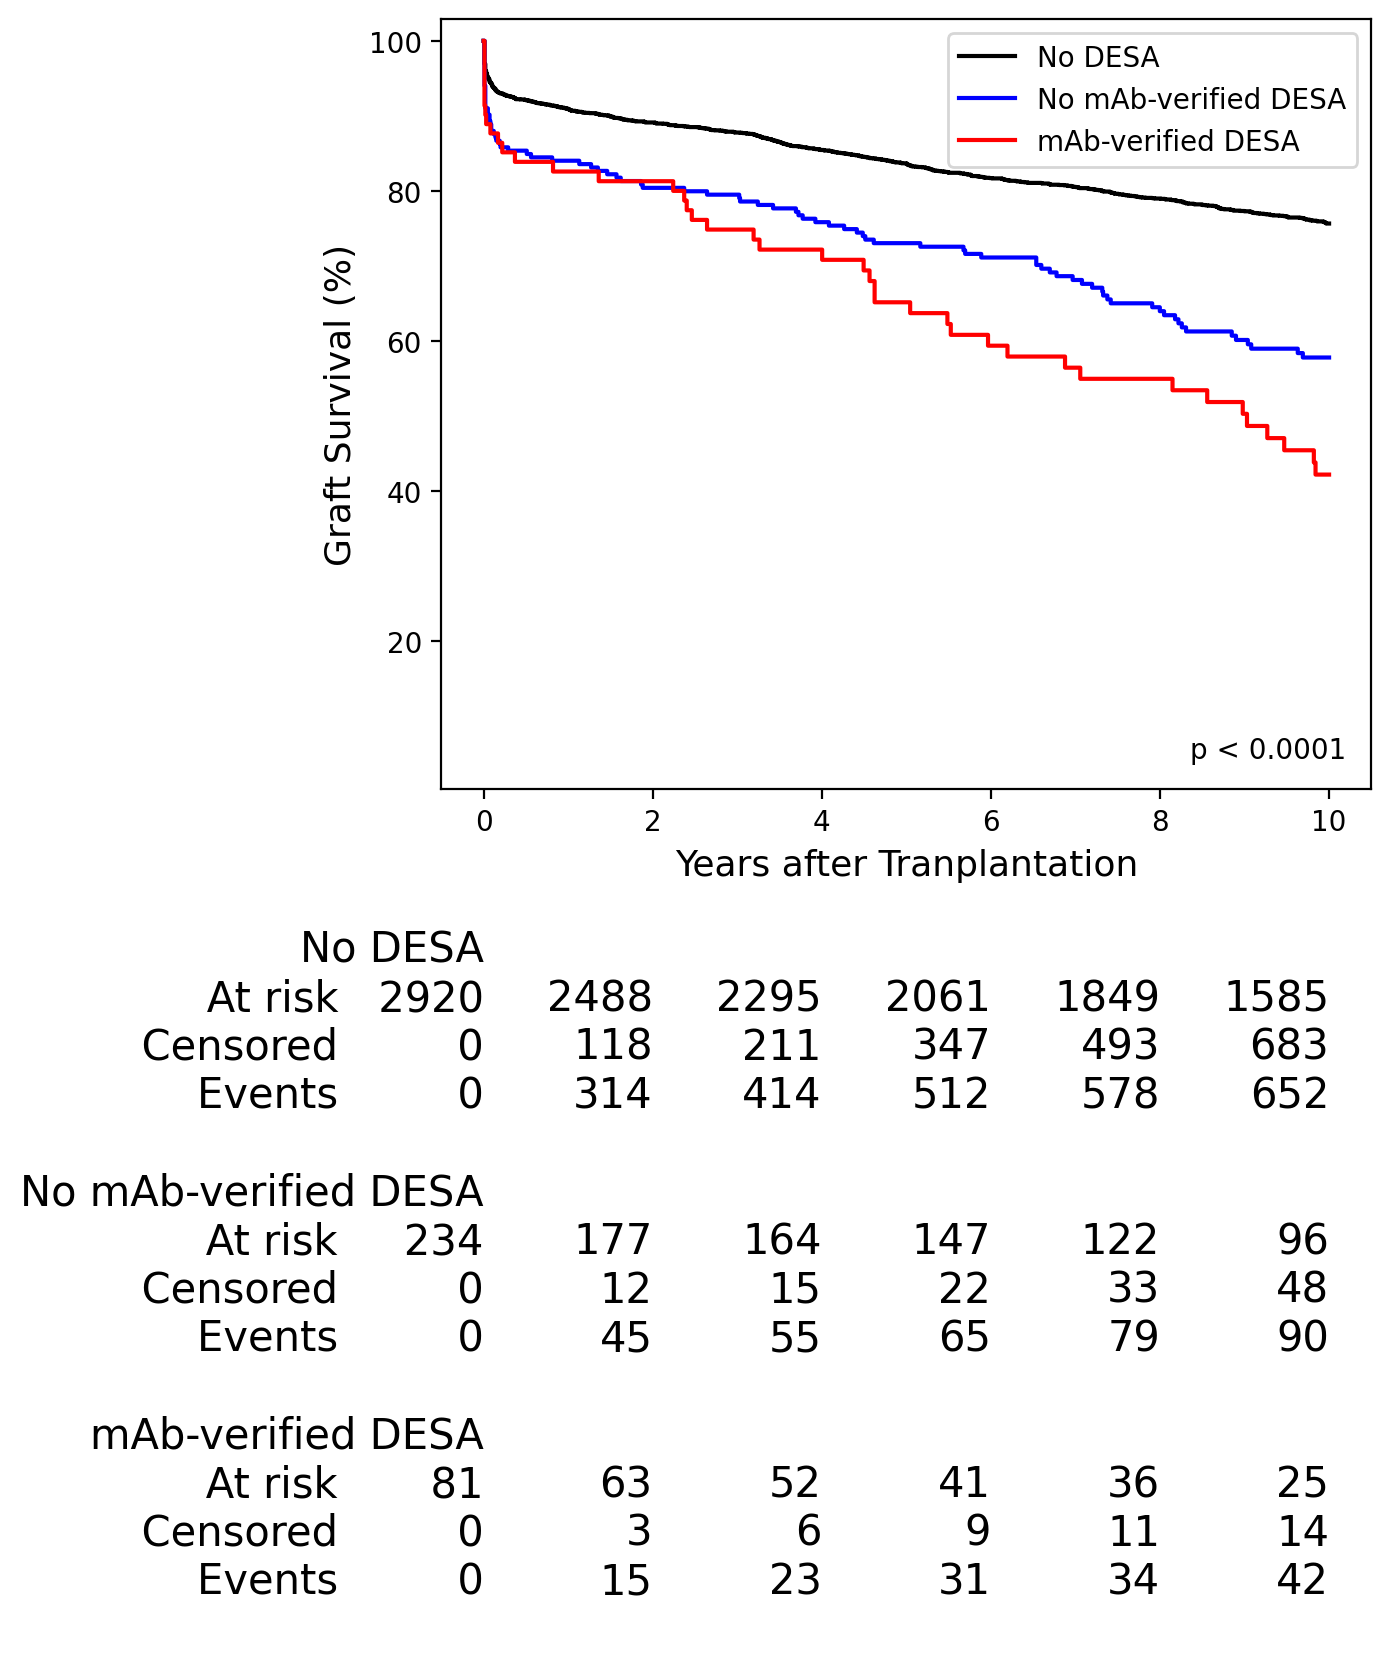

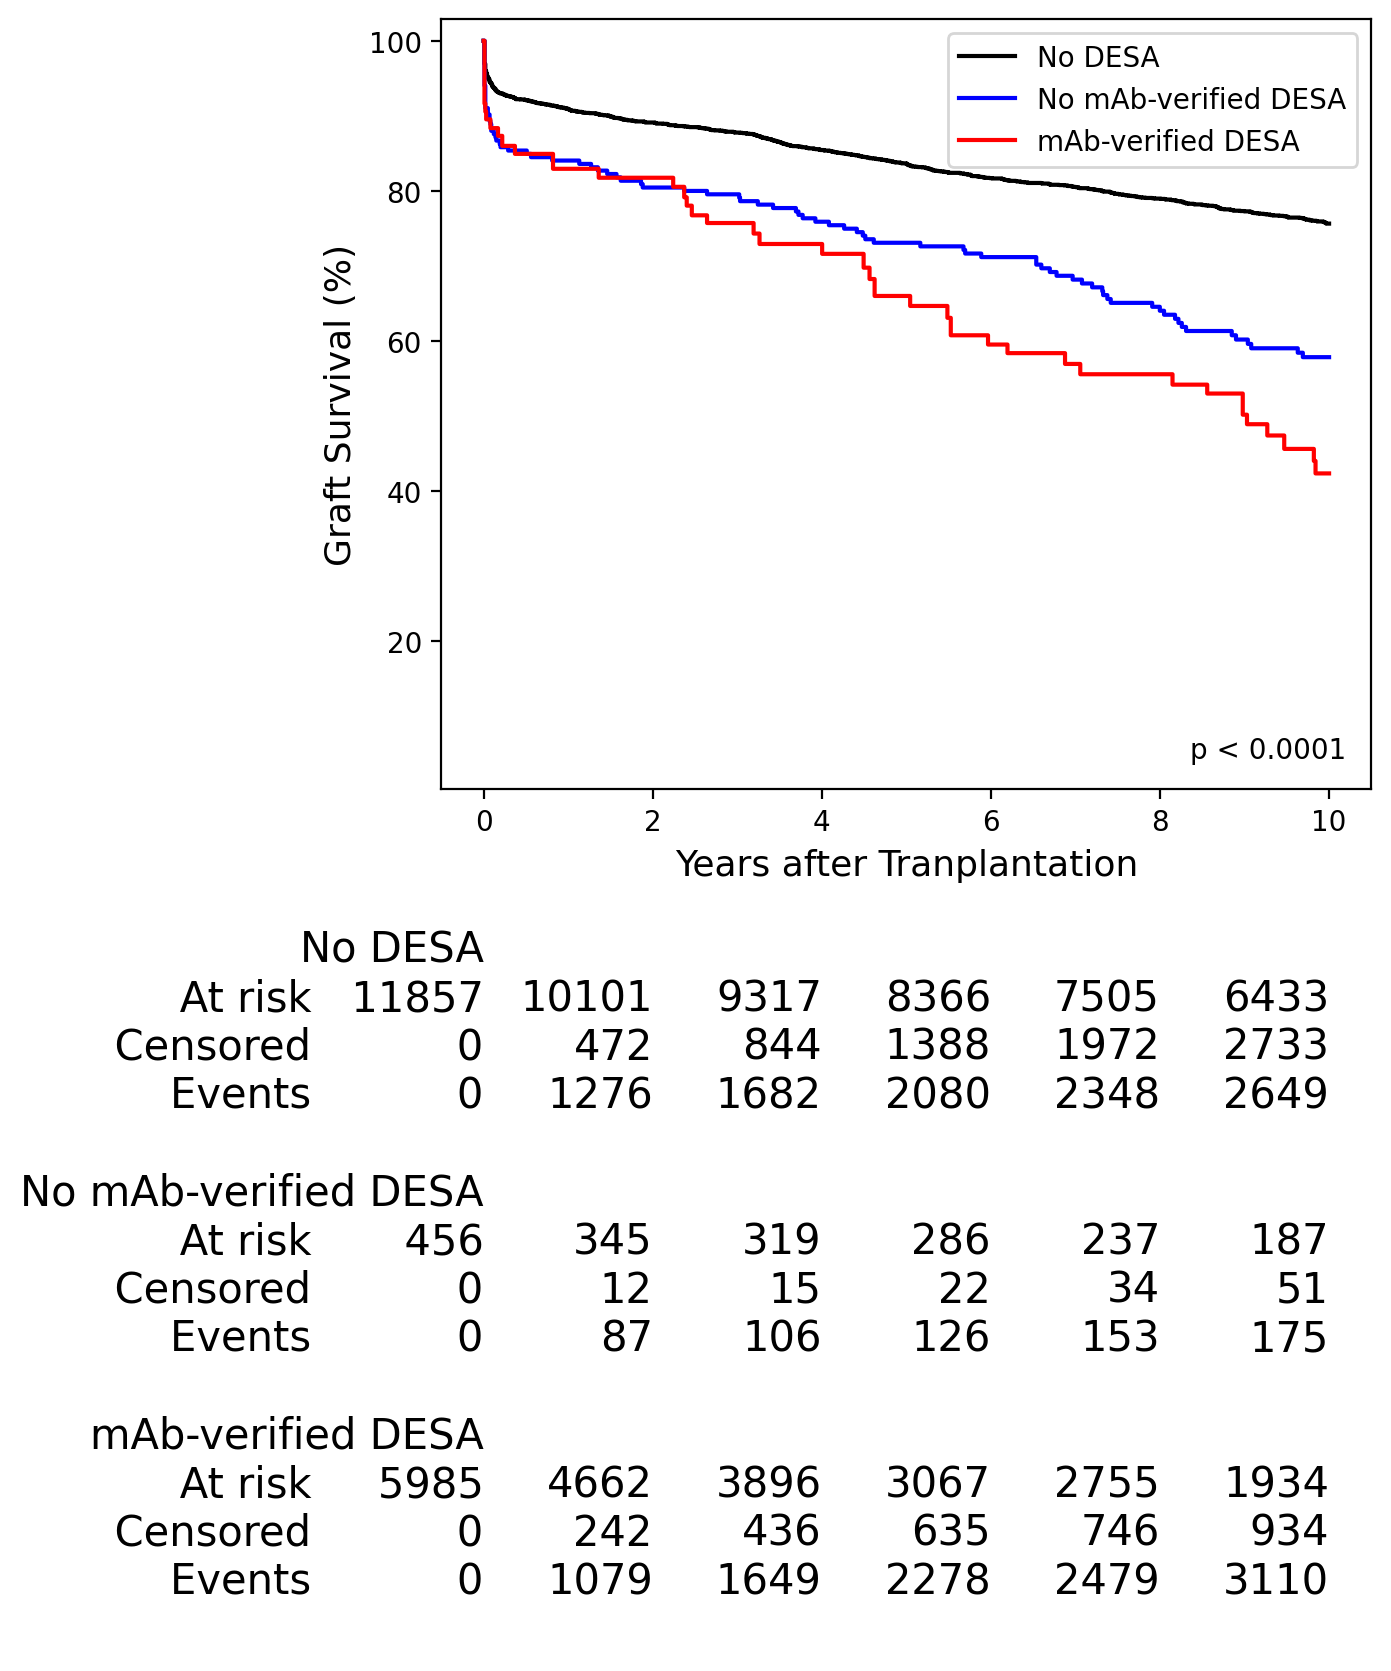

In [5]:
from src.constants import *

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

path = '~/Global Data/EpitopevsHLA.pickle' 
mAbs = get_mAbs(
    path,
    isotype=['IgG']
)
df = df.assign(
                No_DESA = df['DESA'].apply(lambda x: 0 if x else 1),
                mAb_presence = df['DESA'].apply(lambda x: 1 if x.intersection(mAbs) else 0),
                mAb_absence =  df['DESA'].apply(lambda x: 1 if not x.intersection(mAbs) else 0),
            )
df = df.assign(
        Groups = df[['No_DESA', 'mAb_presence', 'mAb_absence']].values.argmax(1) + 1
    )

treatments = ['No_DESA', 'mAb_absence', 'mAb_presence']
df_weight = find_ipw(df, confounders, treatments, verbose=False)
labels = ['No DESA', 'No mAb-verified DESA', 'mAb-verified DESA']
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=mAbs, labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, grid=False, save=True)

kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=mAbs, labels=labels, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, grid=False)

## Truly AB-verified

The former analysis considers the following eplets:

In [6]:
mAbs

{'163RG',
 '41T',
 '57DE',
 '62LQ',
 '65GK',
 '65QIA',
 '65RNA',
 '71TTS',
 '80I',
 '82LR',
 '96HK'}

However, the evidence for some of these is not strong enough to be considered "truly" antibody-verified ([Bezstarosti et al., 2022](https://doi.org/10.3389/fimmu.2021.800946))

In [7]:
truly_verified_eplets = VERIFIED_CLASS_I.union(VERIFIED_CLASS_II)
not_truly_verified_eplets = mAbs.difference(truly_verified_eplets)
not_truly_verified_eplets

{'65RNA', '96HK'}

So we'll repeat the analysis, this time using the set of eplets defined in [Bezstarosti et al. (2022)](https://doi.org/10.3389/fimmu.2021.800946)

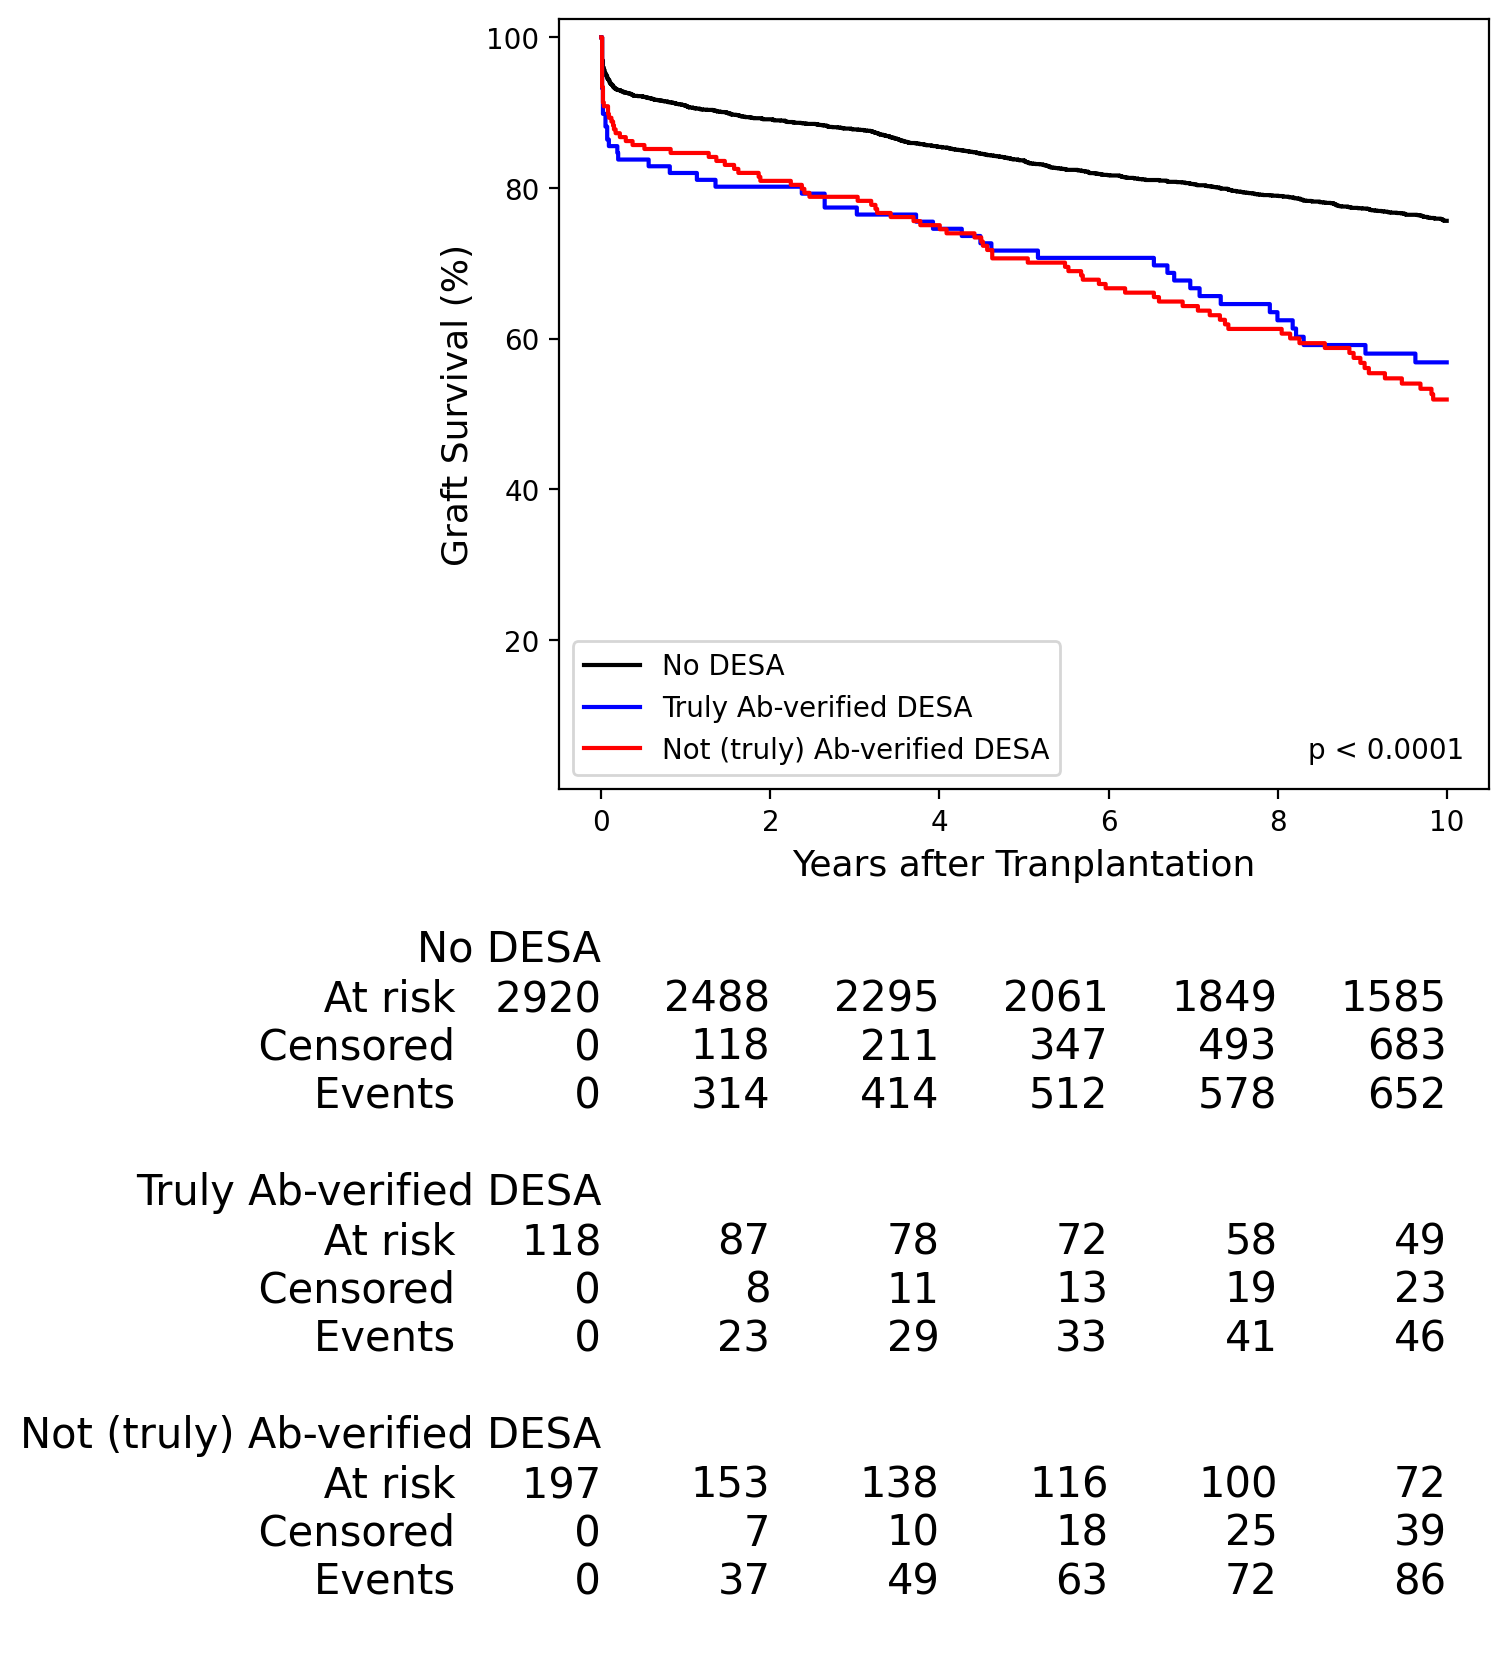

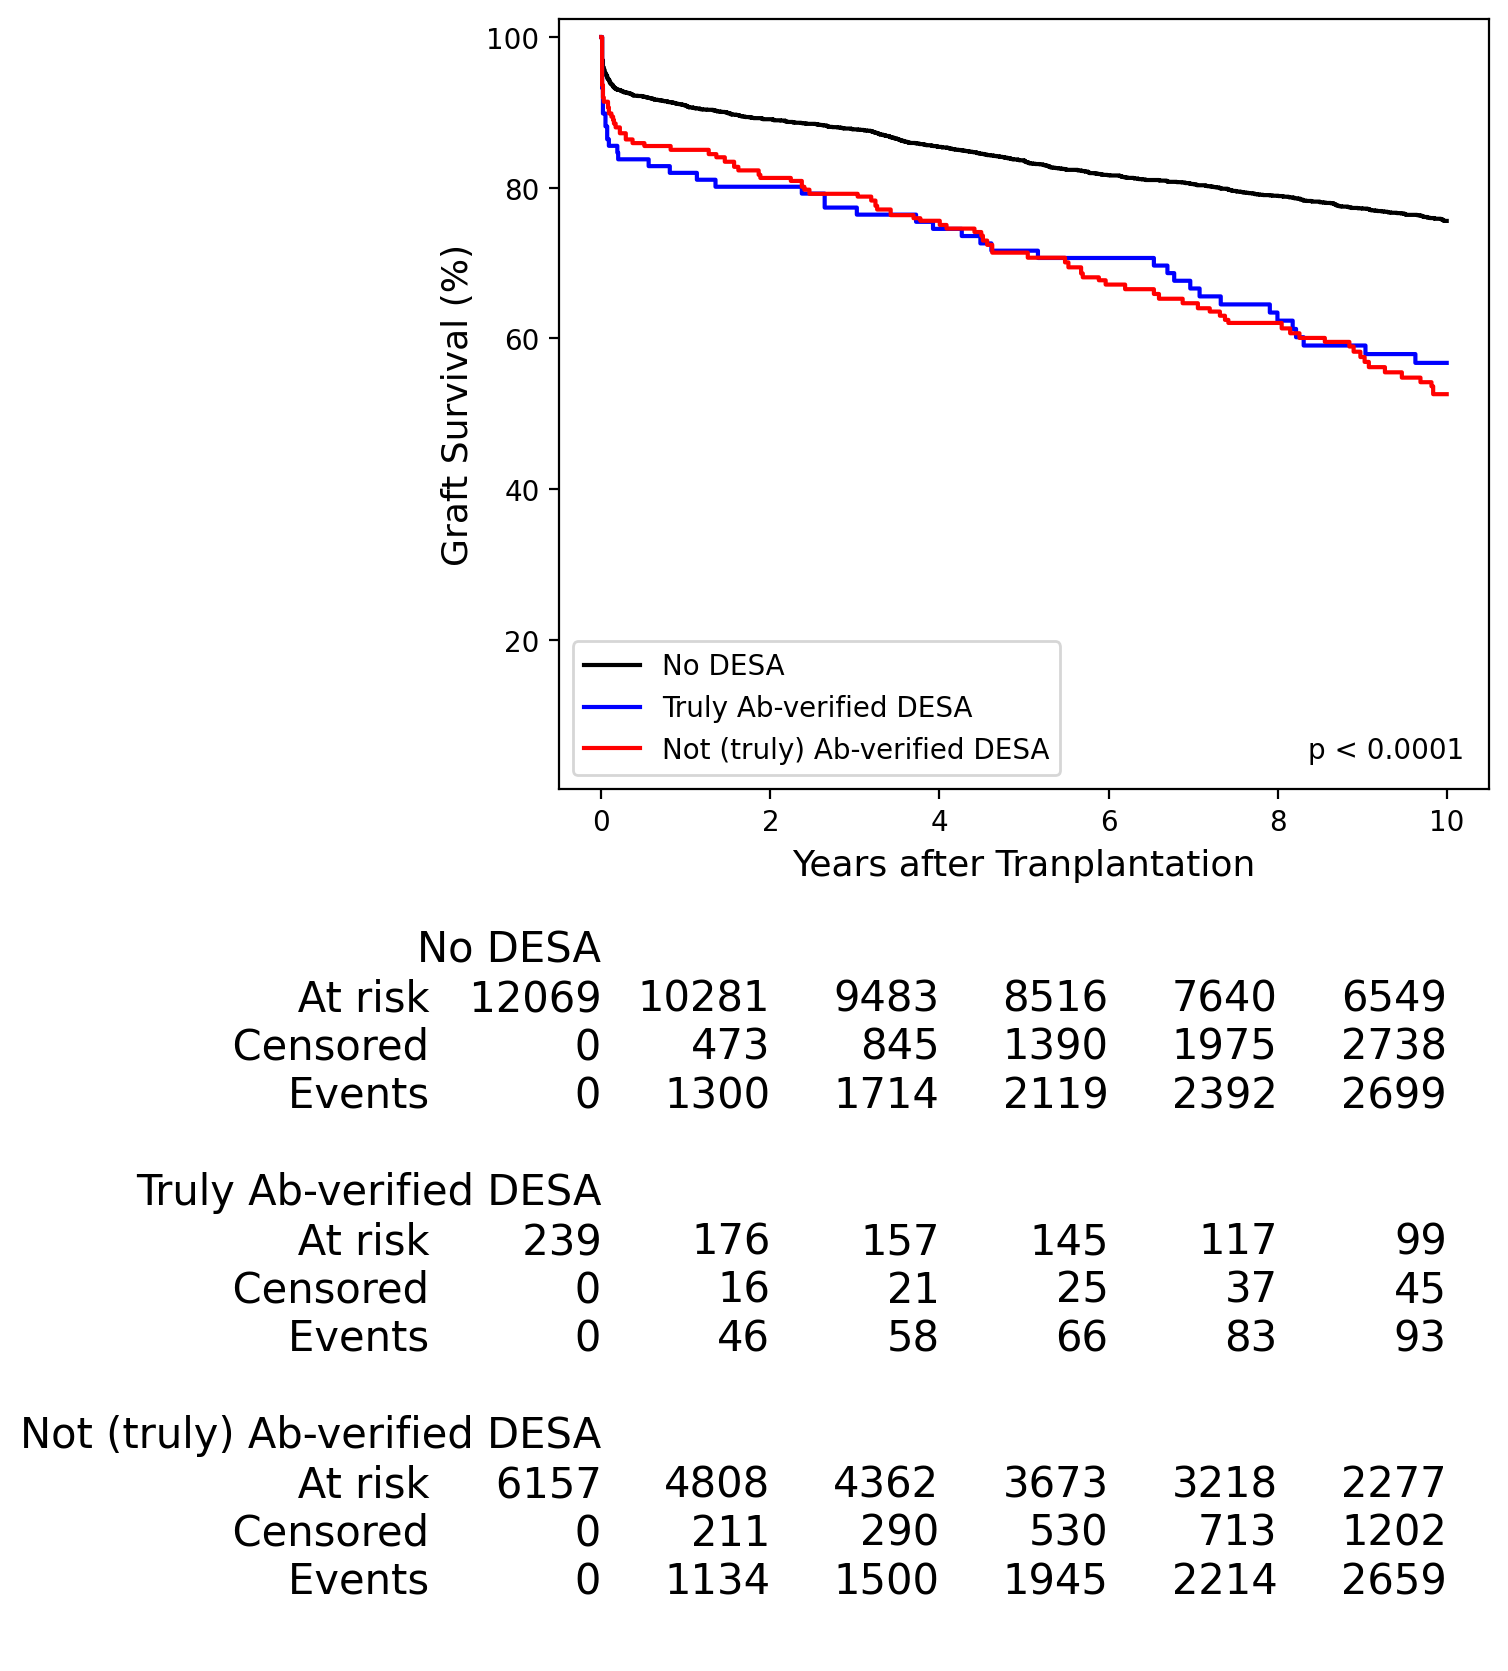

In [8]:
df = df.assign(
                No_DESA = df['DESA'].apply(lambda x: 0 if x else 1),
                ab_verified = df['DESA'].apply(lambda x: 1 if x.intersection(truly_verified_eplets) else 0),
                not_verified = df['DESA'].apply(lambda x: 1 if not x.intersection(truly_verified_eplets) else 0),
            )
df = df.assign(
        Groups = df[['No_DESA', 'ab_verified', 'not_verified']].values.argmax(1) + 1
    )

treatments = ['No_DESA', 'ab_verified', 'not_verified']
df_weight = find_ipw(df, confounders, treatments, verbose=False)
labels = ['No DESA', 'Truly Ab-verified DESA', 'Not (truly) Ab-verified DESA']
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=truly_verified_eplets, labels=labels, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, grid=False, save=True)

kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=truly_verified_eplets, labels=labels, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value, grid=False)